# LoC Data Package Tutorial: Austro-Hungarian maps set

This notebook will demonstrate basic usage of using the Pyton library `boto3` for interacting with [data packages from the Library of Congress](https://labs.loc.gov/data/) via the [Austro-Hungarian map set](https://labs.loc.gov/data/explore/austro-hungarian-maps/) which is derived from the Library's [Austria-Hungary Topographic Set Maps](https://guides.loc.gov/maps-genealogy-eastern-europe/topographic-sets/austria-hungary). We will:

1. [Output a summary of the contents of this data package](#Output-data-package-summary)
2. [Read and query metadata from a data package](#Query-the-metadata-in-a-data-package)
3. [Download and display images from a data package](#Download-and-display-images)

## Prerequisites

In order to run this notebook, please follow the instructions listed in [this directory's README](https://github.com/LibraryOfCongress/data-exploration/blob/master/Data%20Packages/README.md).

## Output data package summary

First, we will select the data package and output a summary of it's contents

In [1]:
import io

import boto3                            # for interacting with Amazon S3 (where the data is stored)
import pandas as pd                     # for reading, manipulating, and displaying data

from helpers import get_s3_bucket_stats

BUCKET_NAME = 'data.labs.loc.gov' # The name of public S3 bucket

# Connect to Amazon S3
s3 = boto3.client('s3')

# This is the name of the data package from the list above; note the trailing slash
DATA_PACKAGE = 'maps/'

stats = get_s3_bucket_stats(s3, BUCKET_NAME, DATA_PACKAGE)

# Convert to Pandas DataFrame and show table
pd.DataFrame(stats)

,FileType,Count,Size
0,.tif,"9,976","1,153.54GB"
1,.zip,3,636MB
2,.dbf,1,8MB
3,.html,3,3MB
4,.json,3,"1,457KB"
5,.txt,5,"1,331KB"
6,.csv,2,968KB
7,.shp,1,678KB
8,.shx,1,40KB
9,.md,2,24KB


## Read the metadata in a data package

First, let's load the data package's `metadata.csv` file:

In [2]:
obj = s3.get_object(Bucket=BUCKET_NAME, Key=f'{DATA_PACKAGE}metadata.csv')
contents = obj.get('Body', '').read() # Read contents as a string

# Read contents as a csv file
csv_string = contents.decode("utf-8")
df = pd.read_csv(io.StringIO(csv_string), dtype=str, keep_default_na=False)
print(f'Loaded metadata file with {df.shape[0]:,} entries.')

Loaded metadata file with 9,885 entries.


Next let's print the available properties

In [3]:
print(', '.join(df.columns.to_list()))

filepath, filename, parent_dir, file_format, object_type, tile_id, edition


## Download and visualize GeoTIFF

Next we will download a GeoTIFF file and visualize it.

First, let's filter to only the GeoTIFF files and take the first one

In [5]:
geotiffs = df[df.file_format == 'GeoTIFF']
print(f'Found {geotiffs.shape[0]:,} GeoTIFF files.')
item = geotiffs.iloc[0]

Found 4,877 GeoTIFF files.


Next download the GeoTIFF file, display it, and visualize a specific band

Opened GeoTIFF file with 3 bands and dimensions: 8,767 x 4,384


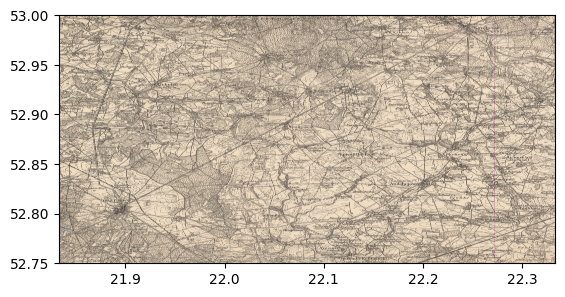

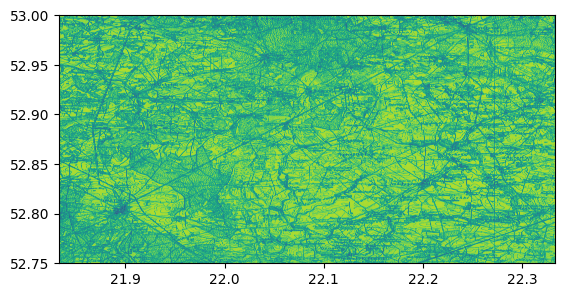

In [10]:
from rasterio.io import MemoryFile
from rasterio.plot import show

filename = f"data/{item['parent_dir']}/{item['filename']}"
obj = s3.get_object(Bucket=BUCKET_NAME, Key=f'{DATA_PACKAGE}{filename}')
filestream = io.BytesIO(obj.get('Body').read())

with MemoryFile(filestream) as memfile:
     with memfile.open() as dataset:
         print(f"Opened GeoTIFF file with {dataset.count} bands and dimensions: {dataset.width:,} x {dataset.height:,}")
         show(dataset)
         visualize_band = 2
         show(dataset.read(visualize_band), transform=dataset.transform, cmap='viridis')
